In [136]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys             
from sympy import *                                # Module to see files and folders in directories
from scipy import stats
from scipy.stats import binom
from scipy.special import binom as binomcoef
from scipy.special import expit
import pandas as pd
import os
from importlib import reload

sys.path.append('../External_Functions')
import ExternalFunctions
reload(ExternalFunctions)
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax, add_header_to_ax

sys.path.append('../Extra_External_Functions')
import EEF
reload(EEF)
from EEF import Datahandler

In [124]:
# Usefull functions
def acceptreject(func, xmin, xmax, ymin, ymax, N_points):
    # Recursive function to do accept/reject monte carlo simulation
    xran = np.random.uniform(xmin, xmax, N_points)
    yran = np.random.uniform(ymin, ymax, N_points)
    yfunc = func(xran)
    xkeep = xran[yran < yfunc]
    missing = N_points - len(xkeep)
    if missing > 0:
        xrest, tries = acceptreject(func, xmin, xmax, ymin, ymax, missing)
    else:
        xrest = np.array([])
        tries = 0
    finalx = np.append(xkeep, xrest)
    finaltries = N_points + tries
    return finalx, finaltries

def acceptrejectdata(func, xmin, xmax, ymin, ymax, N_points):
    x, tries = acceptreject(func, xmin, xmax, ymin, ymax, N_points)
    eff = N_points/tries
    area = (xmax - xmin) * (ymax - ymin) * eff
    return x, tries, area, eff

def F_dis(dataset1, dataset2):
    var1 = np.var(dataset1, ddof = 1)
    var2 = np.var(dataset2, ddof = 1)
    if var1 > var2:
        F = var1/var2
    else:
        F = var2/var1
    print(F)
    return F

def student_t(dataset1, dataset2):
    mean1 = np.mean(dataset1)
    var1 = np.var(dataset1, ddof = 1) #Estimated var
    N1 = len(dataset1)
    mean2 = np.mean(dataset2)
    var2 = np.var(dataset2, ddof = 1) #Estimated var
    N2 = len(dataset2)
    S = np.sqrt(((N1-1)*var1 + (N2-1)*var2)/(N1+N2-2))
    t = (mean1 - mean2)/(S * np.sqrt(1/N1 + 1/N2))
    print(t)
    return t

def geterrors(z, symlist, vals, sigmas):    
    def variances(func, symbols, values, sigmas):
        variance = np.zeros(len(symbols))
        for idx, (symbol, sigma) in enumerate(zip(symbols,sigmas)):
            f = lambdify(symbols, func.diff(symbol)**2 * sigma **2)
            variance[idx] = f(*values)
        return variance
    Vz = variances(z, symlist, vals, sigmas)
    print(Vz)
    sigmaz = np.sqrt(np.sum(Vz))
    zvalue = lambdify(symlist, z)(*vals)
    
    return zvalue, sigmaz

def geterrors_corr(z, symlist, vals, sigmas, corrmatrix):    
    def variances(func, symbols, values, sigmas, corrmatrix):
        # Makes a variance matrix which can we summed and sqrt'ed to find the uncertainty
        # ***Need to be rework to it make more general for more correlations*** 
        # ***Would also be nice to not have a nested loop***
        variance = np.zeros((len(symbols), len(symbols)))
        for idx, (isymbol, isigma) in enumerate(zip(symbols,sigmas)):
            for jdx, (jsymbol, jsigma) in enumerate(zip(symbols,sigmas)):
                
                f = lambdify(symbols, func.diff(isymbol) * func.diff(jsymbol) * isigma * jsigma * corrmatrix[idx, jdx])
                variance[idx, jdx] = f(*values)
        
        return variance
    Vz = variances(z, symlist, vals, sigmas, corrmatrix)
    print(Vz)
    sigmaz = np.sqrt(np.sum(Vz.flatten()))
    zvalue = lambdify(symlist, z)(*vals)
    
    return zvalue, sigmaz 

def basicinfo(data):
    entries = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof = 1)
    eom = std/np.sqrt(entries)
    print(f"Data has {entries:d} entries with the mean = {mean:.3f} +/- {eom:.3f} and std = {std:.3f}")
    return entries, mean, std, eom

def chi2test_onesample(expY, y, sy):
    return np.sum((y - expY)**2/sy**2)

def gensum(pdf, xmin, xmax, ymin, ymax, rn, runs):
    results = np.zeros(runs)
    for i in range(runs):
        xvalues, _ = acceptreject(pdf, xmin, xmax, ymin, ymax, rn)
        results[i] = np.sum(xvalues)
    return results

def weighted_mean(data, error):
    return np.sum((data / error**2)/np.sum(1 / error**2))

def weighted_std(error):
    return np.sqrt(1 / np.sum(1 / error**2))

## Problem 1
#### (1.1)

In [6]:
# The scores of two tests (A & B) are both Gaussianly distributed with μ = 50, σ = 20.
# Part 1. What fraction of students will get a score in test A in the range [55,65]?
# This can be solved using the sf function to 55 - 65
mu = 50
sigma = 20
prob1 = stats.norm.sf(55, mu, sigma) - stats.norm.sf(65, mu, sigma)
print(prob1) # p = 0.17

# Part 2. What uncertainty on the mean score do you obtain from 120 B test scores?
# As the sigma is known and the distributions are gaussian the error on the mean will be sigma/sqrt(N)
eom = sigma/np.sqrt(120)
print(eom) # eom = 1.8

# Part 3. If scores correlate with ρA,B = 0.60, what fraction should get a score above 60 in both tests?
# WIP

0.1746663219402081
1.8257418583505538


#### (1.2)

In [14]:
# A game is designed such that on average 40% of persons will win it.

# Part 1. If 20 random persons play the game, what is the chance that 11 or more will win it?
# A binomial distribution
p = 0.4
N = 20
r = 11
prob2 = stats.binom.sf(r-1, N, p)
print(prob2) # p = 0.13

0.12752124614721688


## Problem 2
#### (2.1)

In [19]:
# Let x = 1.033 ±0.014 and y = 0.07 ±0.23, and let z1 = xye^−y and z2 = (y+ 1)^3/(x−1)
xv = 1.033
xerr = 0.014
yv = 0.07
yerr = 0.23
x, y = symbols("x y")

z1 = x * y * exp(-y)
zv, zerr = geterrors(z1, (x,y), (xv, yv), (xerr, yerr))
# The variance i get is Vz = Vz(x) + Vz(y) = Vz = 8.34931649e-07 + 4.24444573e-02.
# Clearly y contributes more
corrmatrix = np.array([
    [1, 0.4],
    [0.4, 1]
])
z2 = (y+1)**3/(x-1)

z1v, z1err = geterrors_corr(z1, (x,y), (xv, yv), (xerr, yerr), corrmatrix)
print(z1v, z1err) # z1 = 0.07 +/- 0.2
z2v, z2err = geterrors_corr(z2, (x,y), (xv, yv), (xerr, yerr), corrmatrix)
print(z2v, z2err) # z2 = 40 +/- 20

# Part 3. What is the Pearson correlation between z1 and z2 for z1 ∈[−1,1] and z2 ∈[−1,1]? Ill genereate 2000 points in this range
# WIP

[8.34931649e-07 4.24444573e-02]
[[8.34931649e-07 7.53001681e-05]
 [7.53001681e-05 4.24444573e-02]]
0.06742139711739911 0.20638772380872863
[[ 248.0292945  -150.80446023]
 [-150.80446023  573.06701594]]
37.122515151515245 22.792266012270947


#### (2.2)

In [32]:
# In a (Cavendish) experiment, you have made five measurements of Earth’s density ρ:
results = np.array([5.50, 5.61, 4.88, 5.07, 5.26])
results_err = np.array([0.10, 0.21, 0.15, 0.14, 0.13])

# Part 1. What is the combined result and uncertainty of these five measurements?

r = weighted_mean(results, results_err)
r_err = weighted_std(results_err)
print(r, r_err) # with weighted mean and std rho = 5.28 +/- 0.06

def twosampleknownsigma(mean1, sigma1, mean2, sigma2):
    dif = np.abs(mean1 - mean2)
    sigma = np.sqrt(sigma1**2 + sigma2**2) # assuming no correlation
    sigmasfrom0 = dif/sigma
    # two tailed
    # print(sigmasfrom0)
    return 2 * stats.norm.cdf(-sigmasfrom0, 0, 1)

pvalues = []
for idx, (mean1, sigma1) in enumerate(zip(results, results_err)):
    for jdx, (mean2, sigma2) in enumerate(zip(results, results_err)):
        if jdx > idx:
            # print(mean1, mean2)
            p = twosampleknownsigma(mean1, sigma1, mean2, sigma2)
            pvalues.append(p)
print(pvalues)
pvalues2 = []
for p in pvalues:
    pvalues2.append(stats.binom.sf(0,10,p))
print(pvalues2)
# given a 5% significance level
pvalues2 = np.array(pvalues2)
# I see that two pairs of measurements are still in consistantant with eachother
# it is 1 with 3 and 2 with 3
# The uncertainty on 3 is lower than 2 but 1 is lower than 3, 
# and there are two measurements with disagrees with 3 therefore I choose to remove it.
results = np.array([5.50, 5.61, 5.07, 5.26])
results_err = np.array([0.10, 0.21, 0.14, 0.13])
# Then i get
r = weighted_mean(results, results_err)
r_err = weighted_std(results_err)
print(r, r_err) # rho = 5.36 +/- 0.07

# Part 3
# ill measure the amount of sigmas away
# the null is that they are the same value with a 5% significance
truev = 5.514
sigmaaway = np.abs((r - truev)/r_err)
print(sigmaaway) # 2.4184642832633303 sigma away
# this is a two tailed test
p = 2 * stats.norm.sf(2.42, 0, 1)
print(p) #p = 0.02
#The measured quantity is not consistant with the real value.




5.279305828390055 0.06005034708204228
[0.636265305181146, 0.0005835627387778286, 0.012443040766606805, 0.14338371427172408, 0.00467385767994753, 0.03239051203104419, 0.15645118504198452, 0.3544442446165508, 0.0555674896649096, 0.31997685200883286]
[0.9999594634035092, 0.0058203266648449966, 0.11768931668116936, 0.7872530864938421, 0.04576770661445966, 0.2805490635943228, 0.8175675055083513, 0.987429933541025, 0.4354410659256216, 0.9788535746567701]
5.355516150592899 0.06553077938916381
2.4184642832633303
0.015520507101107285


#### (2.3)

In [37]:
# An ellipse E has semi-major axis a = 1.04 ±0.27 and eccentricity e = 0.71 ±0.12.

# Part 1. The area A of an ellipse is generally A = πa2√1 −e2. What is the area of the ellipse E?
a, e = symbols("a e")
av = 1.04
aerr = 0.27
ev = 0.71
eerr = 0.12
area_func = np.pi * a**2 * sqrt(1 - e**2)

area, areaerr =  geterrors(area_func, (a, e), (av, ev), (aerr, eerr))
print(area, areaerr) # A = 2.4 +/- 1.3

cirmin_func = 4 * a * sqrt(2-e**2)
cirmin, cirminerr =  geterrors(cirmin_func, (a, e), (av, ev), (aerr, eerr))
print(cirmin, cirminerr)

cirmax_func = np.pi * a * sqrt(4-2 * e**2)
cirmax, cirmaxerr =  geterrors(cirmax_func, (a, e), (av, ev), (aerr, eerr))
print(cirmax, cirmaxerr)

# Then I take a weighted mean and weighted error to estimate the circumference
cir = weighted_mean(np.array([cirmin, cirmax]), np.array([cirminerr, cirmaxerr]))
cirerr = weighted_std(np.array([cirminerr, cirmaxerr]))
print(cir, cirerr) # C = 5.3 +/- 1.0

[1.54364721 0.16901225]
2.3928396994627668 1.3086861574841329
[1.74481776 0.08397757]
5.087970817526375 1.3523295926287366
[2.15258263 0.10360317]
5.651314683758895 1.502060518464218
5.340172871287868 1.0050205807174966


## Problem 3
#### (3.1)

1.0
0.15865525393145707
0.4932
0.501
0.5028
0.4792
0.4796
0.4762
0.4728
0.4552
0.4576
0.45
0.4422
0.4376
0.418
0.4218
0.4222
0.4094
0.3958
0.403
0.3862
0.3988
0.3836
0.3816
0.358
0.3632
0.3574
0.3518
0.3478
0.3304
0.341
0.3414
0.332
0.3276
0.3102
0.3048
0.295
0.312
0.2958
0.2814
0.2744
0.2774
0.2786
0.2632
0.2472
0.2516
0.2538
0.2372
0.2484
0.2424
0.2246
0.2284
0.2194
0.2148
0.22
0.2096
0.2066
0.1942
0.1954
0.1848
0.1816
0.1794
0.1748
0.1608
0.1666
0.1708
0.1634
0.1614
0.1588
0.1612
0.1516
0.1598
0.138
0.1282
0.1334
0.1322
0.131
0.1202
0.118
0.1198
0.1168
0.113
0.1122
0.1074
0.1012
0.0978
0.0972
0.0994
0.1008
0.0888
0.0858
0.0896
0.0814
0.0836
0.0822
0.077
0.077
0.067
0.0648
0.0618
0.0592
0.0612
0.0564
0.0576
0.0596
0.0556
0.0492
0.0508
0.051
0.052
0.0478
0.0404
0.0492
0.0368
0.0412
0.0406
0.0428
0.039
0.0316
0.0354
0.0314
0.0346
0.0282
0.0314
0.0304
0.0326
0.0278
0.0268
0.0268
0.0246
0.026
0.0248
0.0246
0.0218
0.0204
0.022
0.0184
0.0188
0.0176
0.018
0.0186
0.014
0.0136
0.0124
0.0172
0

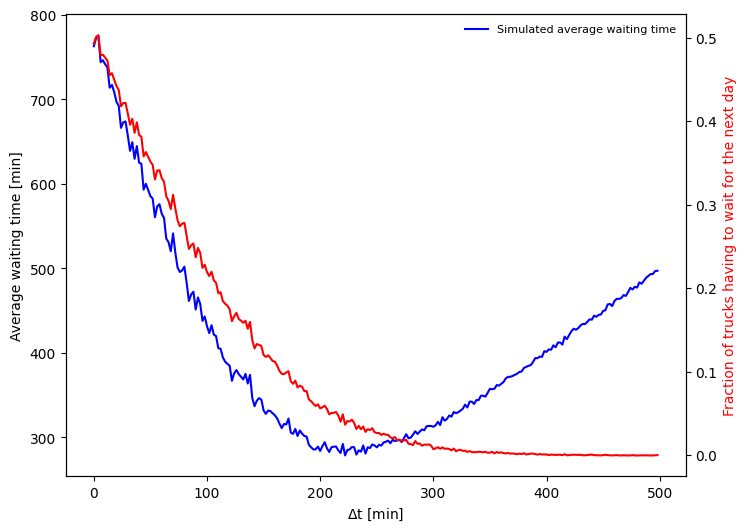

In [88]:
# You are optimising container transport, in particular the time, ∆t, between the daily truck arrivals (120 minutes uncertainty) and the ship departure (50 minutes uncertainty)

# Part 1. If ∆t = 130 minutes, what fraction of containers will have to wait to the next day?

# The two events are assumed to be gaussian distributed

# truck data
tmu = 0
tsigma = 120

# ship data
smu = 130
ssigma = 50

# xlin = np.linspace(tmu - 3* tsigma, smu + 3 * tsigma, 1000)
# ty = stats.norm.pdf(xlin, tmu, tsigma)
# sy = stats.norm.pdf(xlin, smu, ssigma)
# plt.plot(xlin, ty)
# plt.plot(xlin, sy)
# plt.show()


def twosampleknownsigma(mean1, sigma1, mean2, sigma2):
    dif = np.abs(mean1 - mean2)
    sigma = np.sqrt(sigma1**2 + sigma2**2) # assuming no correlation
    sigmasfrom0 = dif/sigma
    # xlin = np.linspace(dif - 3 * sigma, dif + 3 * sigma, 1000)
    # y = stats.norm.pdf(xlin, dif, sigma)
    # plt.plot(xlin, y)
    # one tailed
    print(sigmasfrom0)
    return stats.norm.cdf(-sigmasfrom0, 0, 1)

p = twosampleknownsigma(tmu, tsigma, smu, ssigma)
print(p) # On average 0.16 will miss the ship.
# Do sim to check

# Part 2. For what value of ∆t do containers, on average, have the least waiting time?
N_points = 5000
dtvalues = np.arange(0, 500, 2)
results = np.zeros_like(dtvalues, dtype = np.float64)
fracs = np.zeros_like(dtvalues, dtype = np.float64)
for idx, dt in enumerate(dtvalues):
    smu = dt
    xmin = -tsigma * 3
    xmax = dt + tsigma * 4
    ymin = 0
    t_ymax = stats.norm.pdf(0, 0, tsigma)
    s_ymax = stats.norm.pdf(0, 0, ssigma)
    def gauss_pdf_t(x):
        return stats.norm.pdf(x, tmu, tsigma)
    def gauss_pdf_s(x):
        return stats.norm.pdf(x, smu, ssigma)
    tvalues, _, tarea, _ = acceptrejectdata(gauss_pdf_t, xmin, xmax, ymin, t_ymax, N_points)
    svalues, _, sarea, _ = acceptrejectdata(gauss_pdf_s, xmin, xmax, ymin, s_ymax, N_points)
    # plt.hist(tvalues)
    mask = svalues > tvalues
    arrive_before_wait = svalues[mask] - tvalues[mask]
    arrive_after_wait = np.array([24*60 for i in tvalues[~mask]])
    # print(np.mean(np.append(arrive_before_wait, arrive_after_wait)))
    results[idx] = np.mean(np.append(arrive_before_wait, arrive_after_wait))
    hmm = (~mask).sum()/N_points
    print(hmm)
    fracs[idx] = hmm
res = Datahandler((dtvalues, results, np.zeros_like(results)), binneddata=False)
res.initplot(figsize = (8,6))
res.quickplot(capsize = 0, xlabel = r"$\Delta$t [min]", ylabel = "Average waiting time [min]", label = "Simulated average waiting time")
ax = res.ax
ax2 = ax.twinx()
print(fracs)
ax2.plot(dtvalues, fracs, color = "r", label = "Fraction of trucks having to wait for the next day")
ax2.set_ylabel("Fraction of trucks having to wait for the next day", color = "r")
res.legend()

# best value around dt = 220 with a fraction of 5% which stays 

#### (3.2)

0.33317307955182246
1.0675202805249038


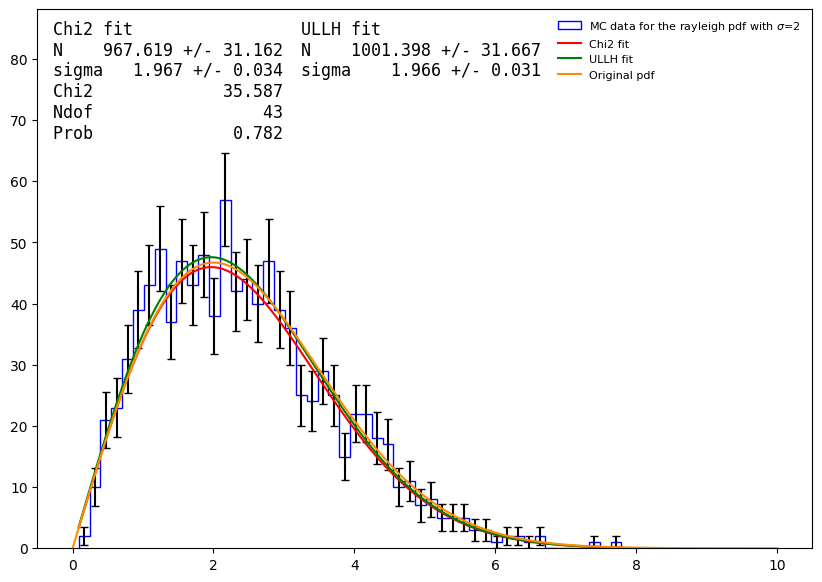

In [143]:
# The Rayleigh distribution is a PDF given by: f(x) = xσ2exp(−12x2/σ2), with x ∈[0,∞]. 
# 
# 
# Part 1. By what method(s) would you generate random numbers (from uniform) according to f(x)?
# This distribution it would be best to use the inversion method as it could take the whole range of x values into account
# Still. that method is more comperesome and I will just do accept/reject from 0 to 5*sigma

# Part 2. Generate N=1000 random numbers according to f(x) for σ = 2, and plot these
N = 1000
sigma = 2
def rayleigh(x):
    return stats.rayleigh.pdf(x, 0, sigma)
xmin = 0
xmax = 5 * sigma
ymin = 0
ymax = stats.rayleigh.pdf(sigma * np.sqrt(2 * np.log(2)), sigma)
print(ymax)

xpoints, _, area, _ = acceptrejectdata(rayleigh, xmin, xmax, ymin, ymax, N)
print(area)

bins = 50
data = Datahandler(xpoints, bins)
data.initplot()
data.quickplot(label = r"MC data for the rayleigh pdf with $\sigma$=2 ")

# Part 3. Fit this distribution of random numbers. How well can you determine σ from the fit?

binwidth = data.binwidth
def rayleighfit(x, N, sigma):
    return N * binwidth * stats.rayleigh.pdf(x, 0, sigma)
data.chi2fit(rayleighfit, N = 1000, sigma = 2)
data.plotfit()
def rayleighfit2(x, N, sigma):
    return N * stats.rayleigh.pdf(x, 0, sigma)
data.ullhfit(rayleighfit2, extended = True, N = 1000, sigma = 1.9)
data.plotfit(topspace = 0, textboxspace = 0.32)
ax = data.ax
xlin = np.linspace(xmin, xmax, 1000)
ax.plot(xlin, rayleighfit(xlin, 1000, 2), label = "Original pdf", color = "darkorange")
data.ax = ax
data.legend()

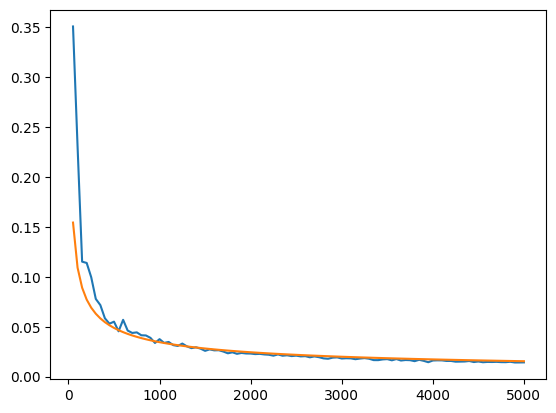

In [155]:
# Part 4
# I did both chi2 and ullh for the one sample, but will just do chi2 for the many samples

Nvalues = np.linspace(50, 5000, 100)
sigma = 2
xmin = 0
xmax = 5 * sigma
ymin = 0
ymax = stats.rayleigh.pdf(sigma * np.sqrt(2 * np.log(2)), sigma)



bins = 50
sigmasigmas = np.zeros_like(Nvalues)
for idx, N in enumerate(Nvalues):
    xpoints, _, area, _ = acceptrejectdata(rayleigh, xmin, xmax, ymin, ymax, int(N))
    data = Datahandler(xpoints, bins)
    binwidth = data.binwidth
    def rayleighfit(x, N, sigma):
        return N * binwidth * stats.rayleigh.pdf(x, 0, sigma)
    _, sigmasigma = data.chi2fit(rayleighfit, N = 1000, sigma = 2)
    sigmasigmas[idx] = sigmasigma[1]
plt.plot(Nvalues, sigmasigmas)
std = np.mean(sigmasigmas*np.sqrt(Nvalues))
def oneoversqrtN(x):
    return std/np.sqrt(x)
plt.plot(Nvalues, oneoversqrtN(Nvalues))
# it looks like the two graphs follow each other well as soon as enough numbers are generated. 

## Problem 4
#### (4.1)

In [ ]:
# Patients are either healthy or infected with Anoroc disease and their temperature, 
# blood pressure and age is found in www.nbi.dk/∼petersen/data AnorocDisease.csv. 
# For patients 1-800 (control) the outcome in known, while it is unknown for patients 801-1000 (unknown).

# Part 1. Using the control sample, plot the three distributions for healthy and sick, respectively. 
# Which of the three single measures gives the highest separation between healthy and sick?

